Guide of using financial packages in python
https://pythonviz.com/finance/yfinance-download-stock-data/

# Section 0

In [ ]:
#@title
# 安裝包
!pip install yfinance

In [ ]:
#@title
# 導入包
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew, jarque_bera, ttest_ind
from csv import writer

In [ ]:
#@title RSI_series(Close, period = 12)
def RSI_series(Close, period = 12):
  # Data cleaning 
  Chg = Close - Close.shift(1)
  Chg_pos = pd.Series(index=Chg.index, data=Chg[Chg>0])
  Chg_pos = Chg_pos.fillna(0)
  Chg_neg = pd.Series(index=Chg.index, data=-Chg[Chg<0])
  Chg_neg = Chg_neg.fillna(0)
    
  # Calculate the average up and average down
  up_mean = []
  down_mean = []
  for i in range(period+1, len(Chg_pos)+1):
    up_mean.append(np.mean(Chg_pos.values[i-period:i]))
    down_mean.append(np.mean(Chg_neg.values[i-period:i]))
    
  # Calculate RSI
  rsi = []
  for i in range(len(up_mean)):
    rsi.append( 100 * up_mean[i] / ( up_mean[i] + down_mean[i] ) )
  rsi_series = pd.Series(index = Close.index[period:], data = rsi)
  
  return rsi_series

In [ ]:
#@title buy_sell_ls(rsi_series, buy_flag = 30, sell_flag = 70)
def buy_sell_ls(rsi_series, buy_flag = 30, sell_flag = 70):
  buy_sell = []
  buy = True
  for i in range(len(rsi_series)-1):
    if buy:
      if rsi_series[i] < buy_flag:
        buy_sell.append(rsi_series.index[i+1])  #index i+1 since signal is delayed, only the next timeframe can the transaction be committed
        buy = False
    else:
      if rsi_series[i] > sell_flag:
        buy_sell.append(rsi_series.index[i+1])  #same reason
        buy = True
  if len(buy_sell) % 2 != 0:  # Make sure buy sell exist in pair
    try: buy_sell.pop()
    except: pass  # Handles empty list exception

  return buy_sell

In [ ]:
#@title getAllSignals(rsi_series, flag, buy = True
def getAllSignals(rsi_series, flag, buy = True):
  """i, d = [], []
  for r in rsi_series.index:
    if (buy and rsi_series[r] < flag) or  (buy == False and rsi_series[r] > flag)
      d.append(rsi_series[r])
      i.append(r)
  series = pd.Series(index = i, data = d)
  return series"""
  if buy:
    return rsi_series[rsi_series < flag]
  else:
    return rsi_series[rsi_series > flag]

In [ ]:
#@title getAllSignalsPrice(Close, series)
def getAllSignalsPrice(Close, series):
  i, c = [], []
  for r in series.index:
    i.append(r)
    c.append(Close[r])
  series = pd.Series(index = i, data = c)
  return series

In [ ]:
#@title Plt_template(title, xl, yl)
def Plt_template(title, xl, yl):
  plt.title(title)
  plt.xlabel(xl)
  plt.ylabel(yl)
  plt.show()
  return

In [ ]:
#@title PltRSIFig(rsi_series, buy_flag = 70, sell_flag = 30))
def PltRSIFig(rsi_series, buy_flag = 70, sell_flag = 30):
  plt.figure(figsize=(10,10))
  x = rsi_series.index
  plt.plot(x, [buy_flag]*len(x), label = 'Buy sinal')
  plt.plot(x,[sell_flag]*len(x), label = 'Sell signal')
  rsi_series.plot(label = 'RSI')
  t = 'Using RSI in Crypoto Currency market, Dataset : yahoofinance 2011-01-01 to 2021-01-01'
  plt.legend()
  Plt_template(t, 'Date', 'RSI')

In [ ]:
#@title getReturn_ls(Close, buy_sell)
def getReturn_ls(Close, buy_sell):
  if len(buy_sell) == 0: return # Handles empty list exceotion
  buy = True
  return_rate = []
  p1 = 0
  for t in buy_sell:
    if buy:
      p1 = Close[t]
      buy = False
    else:
      p2 = Close[t]
      buy = True
      R = (p2 - p1)/p1
      return_rate.append(R)
  return return_rate


In [ ]:
#@title actual_bs(bal, return_ls)
#@markdown return profits, pct_change, bal
def actual_bs(bal, return_ls):
  profits = []
  pct_change = []
  for R in return_ls:
    new_bal = bal * (1+ R)
    profits.append(new_bal - bal)
    pct_change.append(profits[-1] / bal)
    bal = new_bal
    #print('R',R, 'bal',bal)
  return profits, pct_change, bal


In [ ]:
#@title PltProfitsFig(title, profit)
def PltProfitsFig(title, profit):
  plt.figure(figsize=(10,10))
  plt.bar(range(len(profit)), profit)
  print("Mean of profit:", np.mean(profit))
  print("Std of profit:", np.std(profit))
  Plt_template(title, 'RSI Trade cases', 'Profit')

In [ ]:
#@title pltInfluence(xlabel, ylabel, lo, up, v_idx)
#@markdown v = [period, buy_flasg, sell_flag]
def pltInfluence(xlabel, ylabel, lo, up, v_idx):
  v = [period, buy_flag, sell_flag]
  result, params = [], []
  for i in np.arange(lo, up, 1):
    v[v_idx] = i
    bs = buy_sell_ls(RSI_series(Close, period = v[0]), buy_flag = v[1], sell_flag = v[2])
    profit_i, rr_i = bs_strategy(ac, bs, Close)
    result.append(np.mean(rr_i))
    params.append(i)
  plt.plot(params, result)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title('Dataset : yahoofinance')
  plt.show()
  return

In [ ]:
#@title
def sumPrice(data):
  return data.groupby(pd.Grouper(freq='M')).sum()

In [ ]:
#@title get_x_day_Return(series, x = 1)
def get_x_day_Return(series, x = 1):
  i, d = [], []
  for r in range(0,len(series)-x,x):
    d.append(np.log(series[r+x]/series[r]))
    i.append(series.index[r])
  s = pd.Series(index = i, data = d)
  return s

In [ ]:
#@title get_cond_x_day_Return(rsi, Close, buy_flag, sell_flag, x = 10)
def get_cond_x_day_Return(rsi, Close, buy_flag, sell_flag, x = 10):
  bi, si, b, s = [], [], [], []
  r = 0
  while r < len(rsi)-1-x:
    if rsi[r] < buy_flag:
      b.append(np.log(Close[rsi.index[r+1+x]]/Close[rsi.index[r+1]]))
      bi.append(rsi.index[r])
      r = r + x
    elif rsi[r] > sell_flag:
      s.append(np.log(Close[rsi.index[r+1+x]]/Close[rsi.index[r+1]]))
      si.append(rsi.index[r])
      r = r + x
    r += 1
  print(len(b), len(bi), len(s), len(si))
  bs = pd.Series(index = bi, data = b)
  ss = pd.Series(index = si, data = s)
  return bs, ss

In [ ]:
#@title getAll6(return_series)
def getAll6(return_series):
  x_R = return_series
  N = len(x_R)
  m = np.mean(x_R)
  std = np.std(x_R)
  skewness = skew(x_R)
  ex_kurt = kurtosis(x_R)
  JB = jarque_bera(x_R)
  return N, m, std, skewness, ex_kurt, JB

# Section 1 intialization

In [ ]:
# parameters
cc = 'BTC-USD'
stock = '^HSI'
start_date = '2014-10-01'
end_date = '2021-11-01'
sell_flag = 65
buy_flag = 35
period = 12

In [ ]:
#data is from the first market we want to study, like Cryptocurrency market
data = yf.download(cc, start = start_date, end = end_date)
Close = data.Close

[*********************100%***********************]  1 of 1 completed


In [ ]:
def rowGen(c1, series):
  row = [c1] + [len(series)] + [np.mean(series)] + [np.std(series)] + [skew(series)] + [kurtosis(series)] + [jarque_bera(series)]
  return row

In [ ]:
def genRSIrows(Bname, Sname, BSname, B30_70, S30_70, xDayReturn):
  row2 = rowGen(Bname,B30_70) + [ttest_ind(B30_70, xDayReturn)[0]]
  row3 = rowGen(Sname,S30_70) + [ttest_ind(S30_70, xDayReturn)[0]]
  row4 = [BSname]+['NA'] + ['NA'] + ['NA'] + ['NA'] + ['NA'] + ['NA']  + [ttest_ind(B30_70, S30_70)]
  return row2, row3, row4

In [ ]:
def getTable(Close, x, T, marketName):
  xDayReturn = get_x_day_Return(Close, x)
  rsi_T = RSI_series(Close, period = T)
  B30_70, S30_70 = get_cond_x_day_Return(rsi_T, Close, 30, 70, x)
  B20_80, S20_80 = get_cond_x_day_Return(rsi_T, Close, 20, 80, x)
  B40_60, S40_60 = get_cond_x_day_Return(rsi_T, Close, 40, 60, x)
  fileName = marketName + str(x) +'-day-return_RSI' + str(T) +'.csv'
  headers = ['','N','Mean','Std','Skew','Ex_kurt','JB','t']
  with open(fileName, 'w', newline='') as f_object:
    writer_object = writer(f_object)
    writer_object.writerow(headers)
    row1 = rowGen(str(x)+'-Day',xDayReturn) + ['NA']
    row2, row3, row4 = genRSIrows('B(30,70)', 'S(30,70)', 'B-S(30,70)', B30_70, S30_70, xDayReturn)
    row5, row6, row7 = genRSIrows('B(20,80)', 'S(20,80)', 'B-S(20,80)', B20_80, S20_80, xDayReturn)
    row8, row9, row10 = genRSIrows('B(40,60)', 'S(40,60)', 'B-S(40,60)', B40_60, S40_60, xDayReturn)
    writer_object.writerow(row1)
    writer_object.writerow(row2)
    writer_object.writerow(row3)
    writer_object.writerow(row4)
    writer_object.writerow(row5)
    writer_object.writerow(row6)
    writer_object.writerow(row7)
    writer_object.writerow(row8)
    writer_object.writerow(row9)
    writer_object.writerow(row10)
  f_object.close()
  return

In [ ]:
getTable(Close, 10, 14, 'BTC')
getTable(Close, 7, 14, 'BTC')
getTable(Close, 14, 14, 'BTC')
getTable(Close, 10, 7, 'BTC')
getTable(Close, 7, 7, 'BTC')
getTable(Close, 14, 7, 'BTC')
getTable(Close, 10, 21, 'BTC')
getTable(Close, 7, 21, 'BTC')
getTable(Close, 14, 21, 'BTC')

54 54 85 85
21 21 55 55
85 85 119 119
63 63 111 111
21 21 62 62
108 108 163 163
47 47 64 64
17 17 47 47
62 62 93 93
81 81 116 116
58 58 101 101
98 98 123 123
95 95 159 159
74 74 123 123
129 129 173 173
61 61 87 87
52 52 76 76
72 72 93 93
32 32 73 73
9 9 31 31
76 76 114 114
38 38 89 89
9 9 34 34
96 96 152 152
27 27 58 58
7 7 27 27
59 59 87 87


In [ ]:
#data2 and data3 is form different market, we want to compare them
data2 = yf.download(stock, start = '2014-10-01', end = '2021-11-01')
Close2 = data2.Close
data3 = yf.download(cc, start = '2011-01-01', end = '2021-03-01')
Close3 = data3.Close

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
print(Close)
print(Close2)

Date
2014-10-01      383.614990
2014-10-02      375.071991
2014-10-03      359.511993
2014-10-04      328.865997
2014-10-05      320.510010
                  ...     
2021-10-28    60622.136719
2021-10-29    62227.964844
2021-10-30    61888.832031
2021-10-31    61318.957031
2021-11-01    61004.406250
Name: Close, Length: 2585, dtype: float64
Date
2014-10-03    23064.560547
2014-10-06    23315.039062
2014-10-07    23422.519531
2014-10-08    23263.330078
2014-10-09    23534.529297
                  ...     
2021-10-25    26132.029297
2021-10-26    26038.269531
2021-10-27    25628.740234
2021-10-28    25555.730469
2021-10-29    25377.240234
Name: Close, Length: 1743, dtype: float64


In [ ]:
getTable(Close2, 10, 14, 'HSI')
getTable(Close2, 7, 14, 'HSI')
getTable(Close2, 14, 14, 'HSI')
getTable(Close2, 10, 7, 'HSI')
getTable(Close2, 7, 7, 'HSI')
getTable(Close2, 14, 7, 'HSI')
getTable(Close2, 10, 21, 'HSI')
getTable(Close2, 7, 21, 'HSI')
getTable(Close2, 14, 21, 'HSI')

36 36 48 48
13 13 23 23
57 57 78 78
42 42 60 60
16 16 26 26
78 78 95 95
32 32 37 37
10 10 20 20
43 43 59 59
58 58 67 67
36 36 57 57
73 73 75 75
72 72 96 96
41 41 79 79
99 99 105 105
47 47 52 52
31 31 48 48
43 43 67 67
15 15 29 29
4 4 10 10
53 53 63 63
18 18 37 37
5 5 10 10
65 65 82 82
15 15 26 26
4 4 8 8
42 42 49 49


In [ ]:
getTable(Close, 1, 14, 'BTC')
getTable(Close2, 1, 14, 'HSI')

141 141 314 314
43 43 158 158
332 332 546 546
104 104 158 158
31 31 60 60
235 235 299 299


In [ ]:
# Here we create two list witch will store the profit and return rate of all the cases and
# as a result, we could calculate the mean and variance of all the trade cases
def bs_strategy(ac, buy_sell, Close):
  return_ls = getReturn_ls(Close, buy_sell)
  profits, pct_change, bal = actual_bs(ac, return_ls)
  #print("Final account balance:", bal)
  return profits, pct_change

In [ ]:
def RSI(Close, buy_flag = buy_flag, sell_flag = sell_flag, period = period):
  rsi_series = RSI_series(Close, period)
  buy_sell = buy_sell_ls(rsi_series, buy_flag, sell_flag)
  return rsi_series, buy_sell

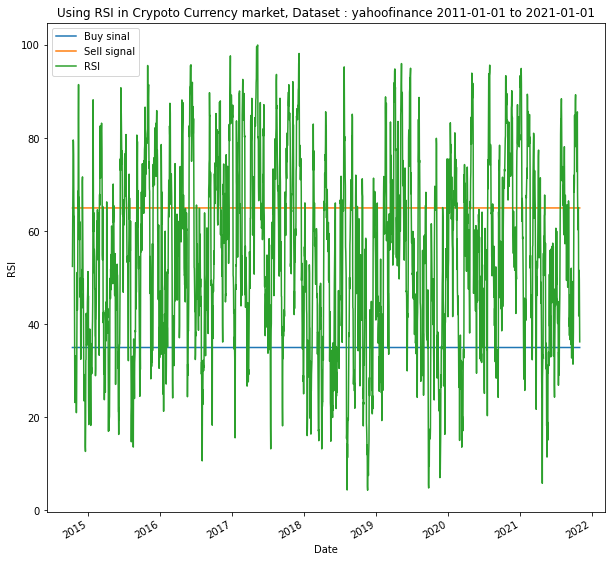

In [ ]:
PltRSIFig(RSI_series(Close), buy_flag, sell_flag)

In [ ]:
#Initialization of RSI buy sell strategy
ac = 10000.0
token = 0.0
buy_sell = buy_sell_ls(RSI_series(Close, period), buy_flag, sell_flag)
profit, return_rate = bs_strategy(ac, buy_sell, Close)
print(buy_sell)

[Timestamp('2014-10-26 00:00:00'), Timestamp('2014-11-11 00:00:00'), Timestamp('2014-11-25 00:00:00'), Timestamp('2014-12-03 00:00:00'), Timestamp('2014-12-10 00:00:00'), Timestamp('2015-01-27 00:00:00'), Timestamp('2015-02-08 00:00:00'), Timestamp('2015-02-28 00:00:00'), Timestamp('2015-03-22 00:00:00'), Timestamp('2015-04-06 00:00:00'), Timestamp('2015-04-14 00:00:00'), Timestamp('2015-05-09 00:00:00'), Timestamp('2015-05-21 00:00:00'), Timestamp('2015-06-14 00:00:00'), Timestamp('2015-07-25 00:00:00'), Timestamp('2015-07-29 00:00:00'), Timestamp('2015-08-07 00:00:00'), Timestamp('2015-09-06 00:00:00'), Timestamp('2015-09-20 00:00:00'), Timestamp('2015-09-29 00:00:00'), Timestamp('2015-11-16 00:00:00'), Timestamp('2015-11-28 00:00:00'), Timestamp('2015-12-28 00:00:00'), Timestamp('2016-01-08 00:00:00'), Timestamp('2016-01-16 00:00:00'), Timestamp('2016-02-15 00:00:00'), Timestamp('2016-03-05 00:00:00'), Timestamp('2016-03-18 00:00:00'), Timestamp('2016-05-20 00:00:00'), Timestamp('20

Mean of profit: 32.63990639504991
Std of profit: 1801.0266078561783


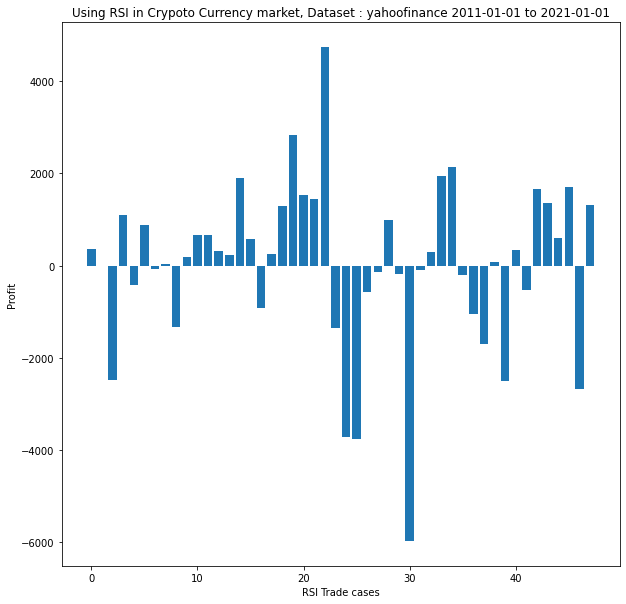

In [ ]:
#The mean of profit with using RSI in Crypoto currency market
t = 'Using RSI in Crypoto Currency market, Dataset : yahoofinance 2011-01-01 to 2021-01-01'
PltProfitsFig(t, profit)

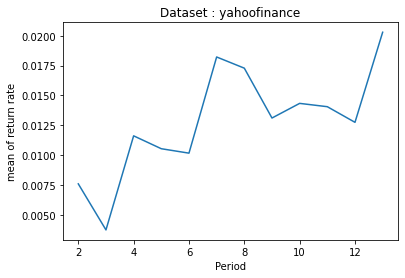

In [ ]:
# See the influence of Peroid
pltInfluence('Period', 'mean of return rate', 2, 14, 0)

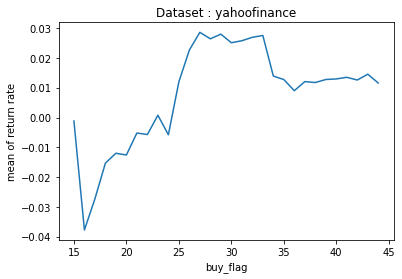

In [ ]:
# See the influence of buy_flag
pltInfluence('buy_flag', 'mean of return rate', 15, 45, 1)

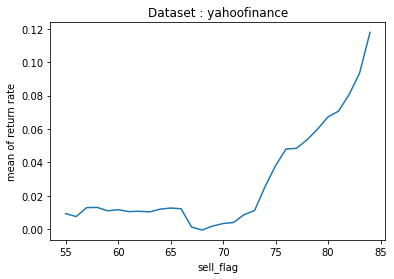

In [ ]:
# See the influence of sell_flag
pltInfluence('sell_flag', 'mean of return rate', 55, 85, 2)

mean return rate -0.020715256798510096
Mean of profit: -247.79480950629474
Std of profit: 1749.0847753251633


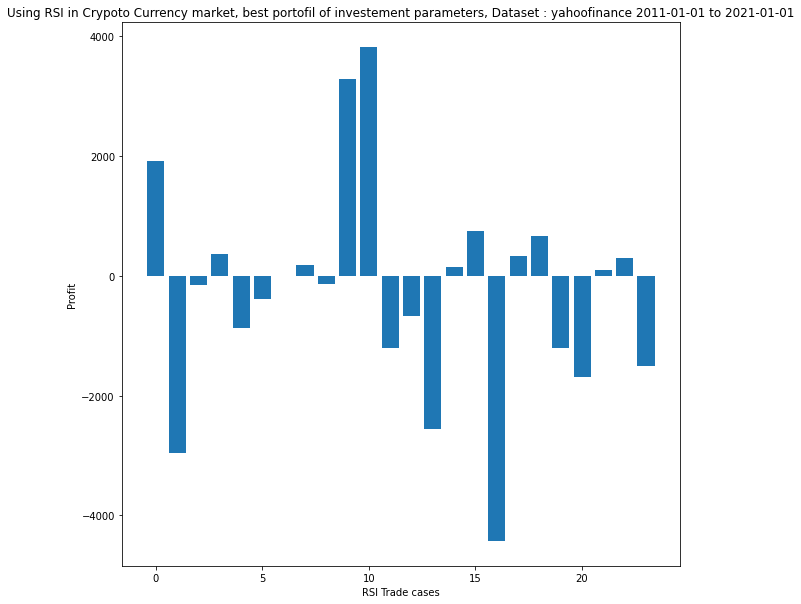

In [ ]:
buy_sell = RSI(Close, buy_flag=24, sell_flag=69, period=12)[1]
profit_op, return_rate_op = bs_strategy(ac, buy_sell, Close)
print('mean return rate', np.mean(return_rate_op))
t_op = 'Using RSI in Crypoto Currency market, best portofil of investement parameters, Dataset : yahoofinance 2011-01-01 to 2021-01-01'
PltProfitsFig(t_op, profit_op)


# Section 2 t-test

If u have no idea about how to realise t-test, just follow this one and using the data of the later 2 block
https://www.jmp.com/zh_cn/statistics-knowledge-portal/t-testtwo-sample-t-test.html

mean return rate 0.006378810181477151
Mean of profit: 59.00741121643078
Std of profit: 466.20309027898537


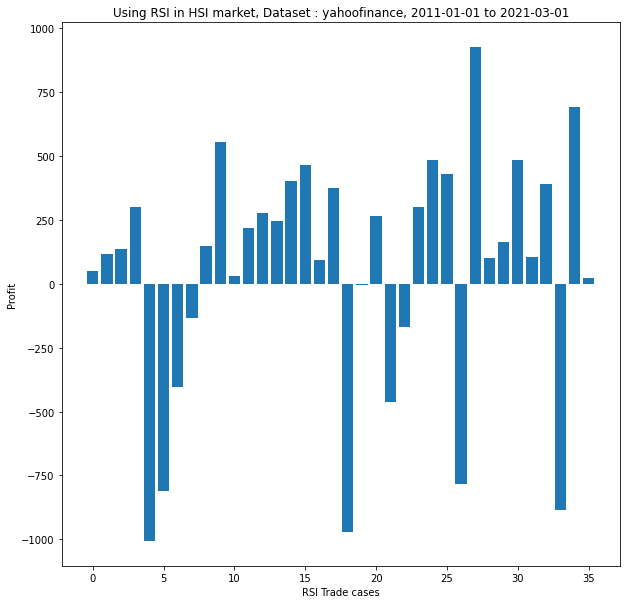

In [ ]:
# This block and next one give perspective of doing t-test, just try to prove in 95%, that the RSI in stock market 
# gives a higher profit that Cryptoc, and it gives us an interesting result that the variance of cc is a lot higher than stock 
buy_sell2 = RSI(Close2)[1]
profit_op2, return_rate_op2 = bs_strategy(ac, buy_sell2, Close2)
print('mean return rate', np.mean(return_rate_op2))
t_op = 'Using RSI in HSI market, Dataset : yahoofinance, 2011-01-01 to 2021-03-01'
PltProfitsFig(t_op, profit = profit_op2)

mean return rate 0.006378810181477151
Mean of profit: 59.00741121643078
Std of profit: 466.20309027898537


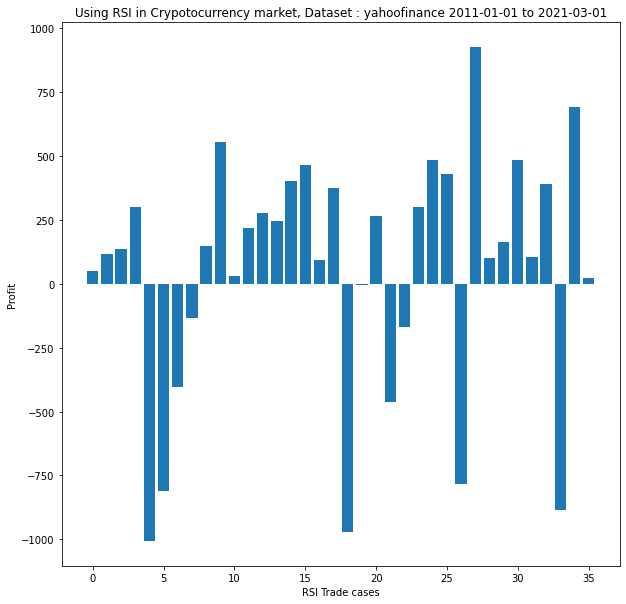

In [ ]:
buy_sell3 = RSI(Close3)[1]
profit_op3, return_rate_op3 = bs_strategy(ac, buy_sell3, Close3)
print('mean return rate', np.mean(return_rate_op2))
t_op = 'Using RSI in Crypotocurrency market, Dataset : yahoofinance 2011-01-01 to 2021-03-01'
PltProfitsFig(t_op, profit = profit_op2)

In [ ]:
ttest_ind(profit_op3, profit_op2)

Ttest_indResult(statistic=-0.2476169343630398, pvalue=0.8050814697533092)